### 🧠 Final Model Summary – Predicting Legendary Status

After experimenting with multiple models, the best-performing setup used a **Multilayer Perceptron (MLP)** to predict whether a Pokémon is **Legendary** based on a combination of base stats, categorical traits, and engineered features.

---

#### 📁 Dataset Overview

- **Kaggle Pokémon Database**: https://www.kaggle.com/datasets/mrdew25/pokemon-database  
- **Total Pokémon used**: `1,382` (including alternate forms)
- **Target variable**: `Legendary Type`  
  - Transformed into a **binary classification** (`0 = Not Legendary`, `1 = Legendary`)

---

#### 🧪 Features Used
- Total: `858` after preprocessing
- Raw stats: `Health`, `Attack`, `Defense`, `Sp. Attack`, `Sp. Defense`, `Speed`
- Composite stat: `Base Stat Total`
- Normalized stats: `(Base Stat / Base Stat Total) * 100`
- Categorical traits: `Primary/Secondary Egg Groups`, `Primary Ability`, `Classification`
- Boolean flag: `is_pre_evolution` (whether the Pokémon has a pre-evo)

---

#### ✅ Model Overview
- **Model**: `MLPClassifier` (Neural Network)
- **Architecture**: 2 hidden layers with 256 and 128 neurons respectively
- **Training Strategy**: 80/20 stratified train-test split
- **Loss Optimization**: Backpropagation with gradient descent (`max_iter=500`)
- **Evaluation Metric**: [Kappa]

---

#### 📊 Results
- **Kappa Score**: **`0.946`**
- **Accuracy**: **~99%**
- **Class balance**: Model performed well despite Legendary status being a **minority class**
- **Confusion matrix**: Excellent separation between legendary and non-legendary Pokémon

---

#### 🔍 Feature Insights (via Permutation Importance)
Top predictors:
- In MLP the top 15 features were all abilities
- In RF top 15 features were primarily base stats but the #1 feature was `no egg groups discovered `

---

#### ⚠️ Features That Hurt or Had No Impact
- Adding types either primary or secondary only hurt performance
- Adding `Type Combo` (as a single feature) instead of separate primary/secondary types **had no additional benefit**


---

#### 🎯 Key Takeaways
- MLPClassifier outperformed RF (Kappa = 0.946 vs .85) yet again
- Including **alternate forms** had a massive impact — improving Kappa by **0.10 in both models**



/var/folders/ht/dp3tdfgs34g1r1j0jdjb1qq40000gn/T/ipykernel_45669/4114169316.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip('"') if isinstance(x, str) else x)


Test set size: 277
Class distribution (test): [246  31]

📋 Classification Report:
               precision    recall  f1-score   support

Not Legendary       1.00      0.99      0.99       246
    Legendary       0.94      0.97      0.95        31

     accuracy                           0.99       277
    macro avg       0.97      0.98      0.97       277
 weighted avg       0.99      0.99      0.99       277

Kappa Score: 0.946


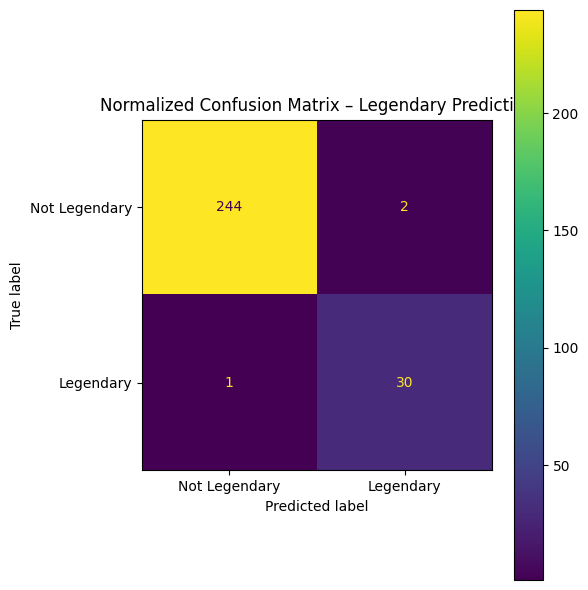

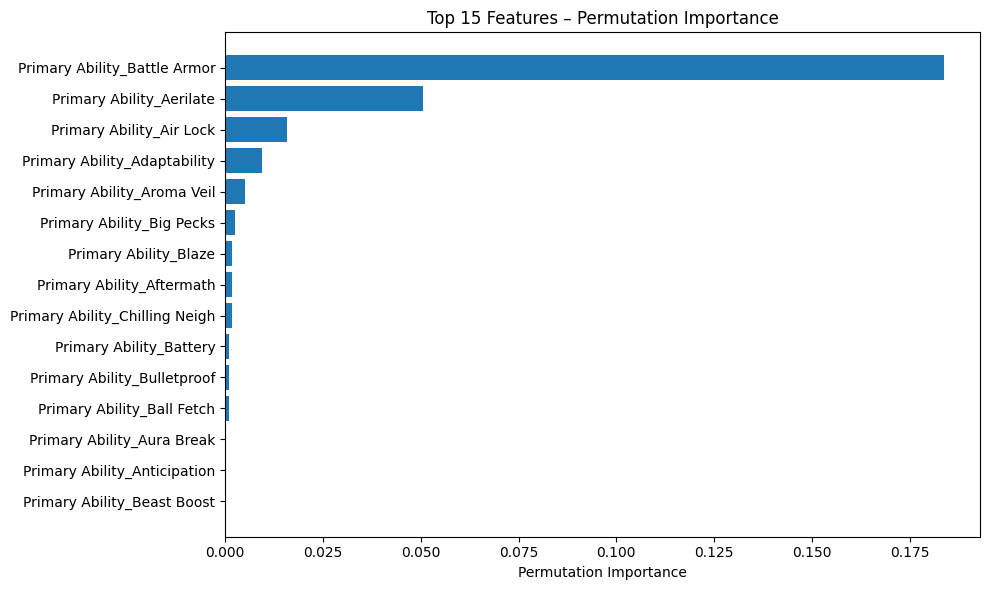

In [ ]:
import pandas as pd
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, cohen_kappa_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Load and clean
df = pd.read_csv("../../data/pokemon_database.csv")
df = df.applymap(lambda x: x.strip('"') if isinstance(x, str) else x)
# df = df[df['Alternate Form Name'].isnull()]
df['Classification'] = df['Classification'].str.replace("(?i)\\s*pokemon\\s*", "", regex=True).str.strip()

# 🎯 Target: Binary 'is_legendary' column
df['is_legendary'] = df['Legendary Type'].notnull().astype(int)

# Features
features = [
    'Primary Ability', 'Primary Egg Group', 'Secondary Egg Group',
    'Classification', 'Health Stat', 'Attack Stat', 'Defense Stat',
    'Special Attack Stat', 'Special Defense Stat', 'Speed Stat',
    'Base Stat Total'
]
df['is_pre_evolution'] = df['Pokemon Id'].isin(df['Pre-Evolution Pokemon Id'].dropna().astype(int))
features.append('is_pre_evolution')

# Normalize stats
for stat in ['Health Stat', 'Attack Stat', 'Defense Stat',
             'Special Attack Stat', 'Special Defense Stat', 'Speed Stat']:
    pct = f"{stat}_pct"
    df[pct] = (df[stat] / df['Base Stat Total']) * 100
    features.append(pct)

# Drop missing target
df_model = df[features + ['is_legendary']].dropna(subset=['is_legendary'])

X = df_model[features]
y = df_model['is_legendary']

categorical_features = ['Primary Ability', 'Primary Egg Group', 'Secondary Egg Group', 'Classification']
numeric_features = [col for col in X.columns if col not in categorical_features]

# Preprocessing
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('num', 'passthrough', numeric_features)
])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(hidden_layer_sizes=(256, 128), max_iter=500, learning_rate_init=0.001, random_state=42))
])

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Train + Predict
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation
print("Test set size:", len(y_test))
print("Class distribution (test):", np.bincount(y_test))
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Not Legendary", "Legendary"]))

print("Kappa Score:", round(cohen_kappa_score(y_test, y_pred), 3))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Legendary", "Legendary"])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax)
plt.title("Normalized Confusion Matrix – Legendary Prediction")
plt.tight_layout()
plt.show()


# --- Feature names after encoding ---
onehot = model.named_steps['preprocessor'].transformers_[0][1]
cat_features = onehot.get_feature_names_out(categorical_features)
all_features = np.concatenate([cat_features, numeric_features])

### 🔄 2. Permutation Importance (RF or MLP)
# Use the current model to evaluate
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
perm_importances = result.importances_mean
perm_indices = np.argsort(perm_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.barh(range(15), perm_importances[perm_indices][:15][::-1])
plt.yticks(range(15), all_features[perm_indices][:15][::-1])
plt.xlabel("Permutation Importance")
plt.title("Top 15 Features – Permutation Importance")
plt.tight_layout()
plt.show()

#### ✅ Model - MLP (Individual Types)

/var/folders/ht/dp3tdfgs34g1r1j0jdjb1qq40000gn/T/ipykernel_45669/1495146709.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip('"') if isinstance(x, str) else x)


Test set size: 277
Class distribution (test): [246  31]

📋 Classification Report:
               precision    recall  f1-score   support

Not Legendary       0.98      0.99      0.99       246
    Legendary       0.93      0.84      0.88        31

     accuracy                           0.97       277
    macro avg       0.95      0.92      0.93       277
 weighted avg       0.97      0.97      0.97       277

Kappa Score: 0.867


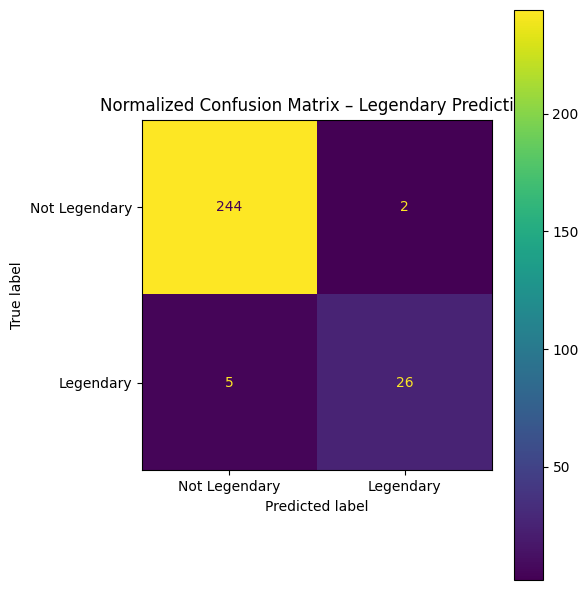

In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, cohen_kappa_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Load and clean
df = pd.read_csv("../../data/pokemon_database.csv")
df = df.applymap(lambda x: x.strip('"') if isinstance(x, str) else x)
# df = df[df['Alternate Form Name'].isnull()]
df['Classification'] = df['Classification'].str.replace("(?i)\\s*pokemon\\s*", "", regex=True).str.strip()

# 🎯 Target: Binary 'is_legendary' column
df['is_legendary'] = df['Legendary Type'].notnull().astype(int)

# Features
features = [
    'Primary Ability', 'Primary Egg Group', 'Secondary Egg Group',
    'Classification', 'Health Stat', 'Attack Stat', 'Defense Stat',
    'Special Attack Stat', 'Special Defense Stat', 'Speed Stat',
    'Base Stat Total', 'Primary Type', 'Secondary Type'
]
df['is_pre_evolution'] = df['Pokemon Id'].isin(df['Pre-Evolution Pokemon Id'].dropna().astype(int))
features.append('is_pre_evolution')

# Normalize stats
for stat in ['Health Stat', 'Attack Stat', 'Defense Stat',
             'Special Attack Stat', 'Special Defense Stat', 'Speed Stat']:
    pct = f"{stat}_pct"
    df[pct] = (df[stat] / df['Base Stat Total']) * 100
    features.append(pct)

# Drop missing target
df_model = df[features + ['is_legendary']].dropna(subset=['is_legendary'])

X = df_model[features]
y = df_model['is_legendary']

categorical_features = ['Primary Ability', 'Primary Egg Group', 'Secondary Egg Group', 'Classification', 'Primary Type', 'Secondary Type']
numeric_features = [col for col in X.columns if col not in categorical_features]

# Preprocessing
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('num', 'passthrough', numeric_features)
])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(hidden_layer_sizes=(256, 128), max_iter=500, learning_rate_init=0.001, random_state=42))
])

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Train + Predict
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation
print("Test set size:", len(y_test))
print("Class distribution (test):", np.bincount(y_test))
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Not Legendary", "Legendary"]))

print("Kappa Score:", round(cohen_kappa_score(y_test, y_pred), 3))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Legendary", "Legendary"])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax)
plt.title("Normalized Confusion Matrix – Legendary Prediction")
plt.tight_layout()
plt.show()


#### ✅ Model - MLP (Type Combo)

/var/folders/ht/dp3tdfgs34g1r1j0jdjb1qq40000gn/T/ipykernel_45669/321937722.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip('"') if isinstance(x, str) else x)


Test set size: 277
Class distribution (test): [246  31]

📋 Classification Report:
               precision    recall  f1-score   support

Not Legendary       0.99      0.99      0.99       246
    Legendary       0.93      0.90      0.92        31

     accuracy                           0.98       277
    macro avg       0.96      0.95      0.95       277
 weighted avg       0.98      0.98      0.98       277

Kappa Score: 0.908


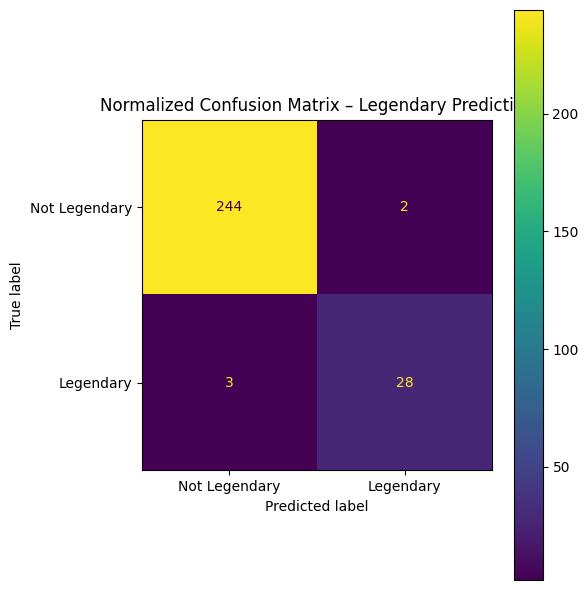

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, cohen_kappa_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Load and clean
df = pd.read_csv("../../data/pokemon_database.csv")
df = df.applymap(lambda x: x.strip('"') if isinstance(x, str) else x)
# df = df[df['Alternate Form Name'].isnull()]
df['Classification'] = df['Classification'].str.replace("(?i)\\s*pokemon\\s*", "", regex=True).str.strip()

df['type_combo'] = df['Primary Type'] + '/' + df['Secondary Type'].fillna("")


# 🎯 Target: Binary 'is_legendary' column
df['is_legendary'] = df['Legendary Type'].notnull().astype(int)

# Features
features = [
    'Primary Ability', 'Primary Egg Group', 'Secondary Egg Group',
    'Classification', 'Health Stat', 'Attack Stat', 'Defense Stat',
    'Special Attack Stat', 'Special Defense Stat', 'Speed Stat',
    'Base Stat Total', 'type_combo'
]
df['is_pre_evolution'] = df['Pokemon Id'].isin(df['Pre-Evolution Pokemon Id'].dropna().astype(int))
features.append('is_pre_evolution')

# Normalize stats
for stat in ['Health Stat', 'Attack Stat', 'Defense Stat',
             'Special Attack Stat', 'Special Defense Stat', 'Speed Stat']:
    pct = f"{stat}_pct"
    df[pct] = (df[stat] / df['Base Stat Total']) * 100
    features.append(pct)

# Drop missing target
df_model = df[features + ['is_legendary']].dropna(subset=['is_legendary'])

X = df_model[features]
y = df_model['is_legendary']

categorical_features = ['Primary Ability', 'Primary Egg Group', 'Secondary Egg Group', 'Classification', 'type_combo']
numeric_features = [col for col in X.columns if col not in categorical_features]

# Preprocessing
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('num', 'passthrough', numeric_features)
])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(hidden_layer_sizes=(256, 128), max_iter=500, learning_rate_init=0.001, random_state=42))
])

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Train + Predict
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation
print("Test set size:", len(y_test))
print("Class distribution (test):", np.bincount(y_test))
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Not Legendary", "Legendary"]))

print("Kappa Score:", round(cohen_kappa_score(y_test, y_pred), 3))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Legendary", "Legendary"])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax)
plt.title("Normalized Confusion Matrix – Legendary Prediction")
plt.tight_layout()
plt.show()


#### ✅ Model - RF

/var/folders/ht/dp3tdfgs34g1r1j0jdjb1qq40000gn/T/ipykernel_45669/731475700.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip('"') if isinstance(x, str) else x)


Test set size: 277
Class distribution (test): [246  31]

📋 Classification Report:
               precision    recall  f1-score   support

Not Legendary       0.98      0.99      0.98       246
    Legendary       0.90      0.84      0.87        31

     accuracy                           0.97       277
    macro avg       0.94      0.91      0.93       277
 weighted avg       0.97      0.97      0.97       277

Kappa Score: 0.85


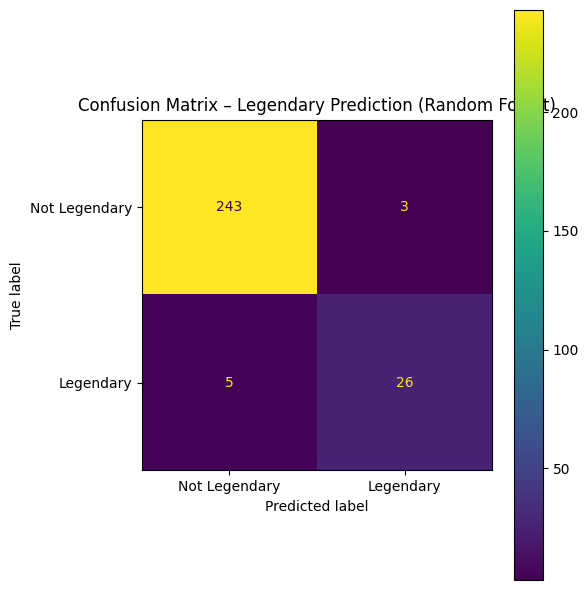

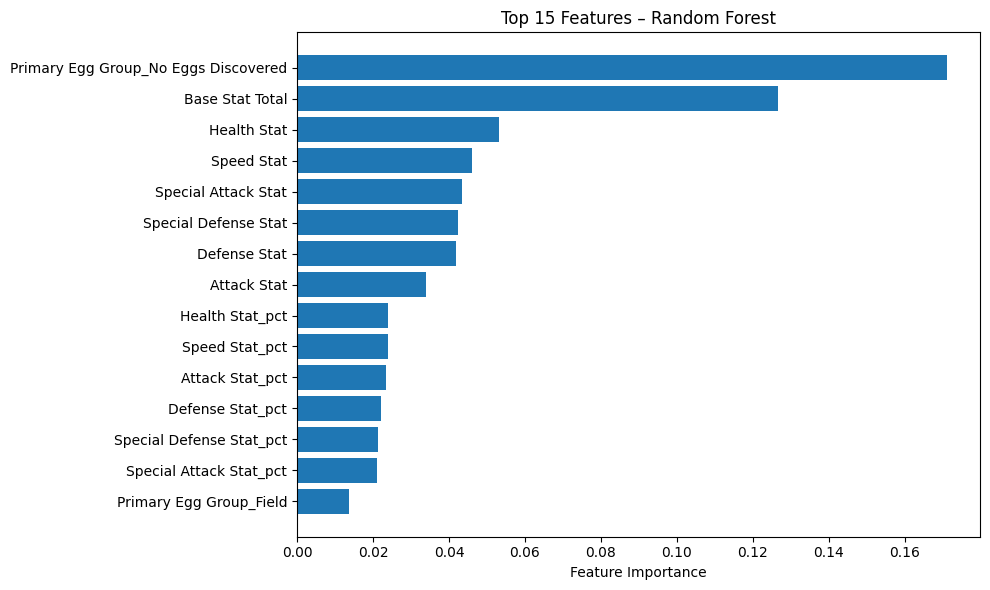

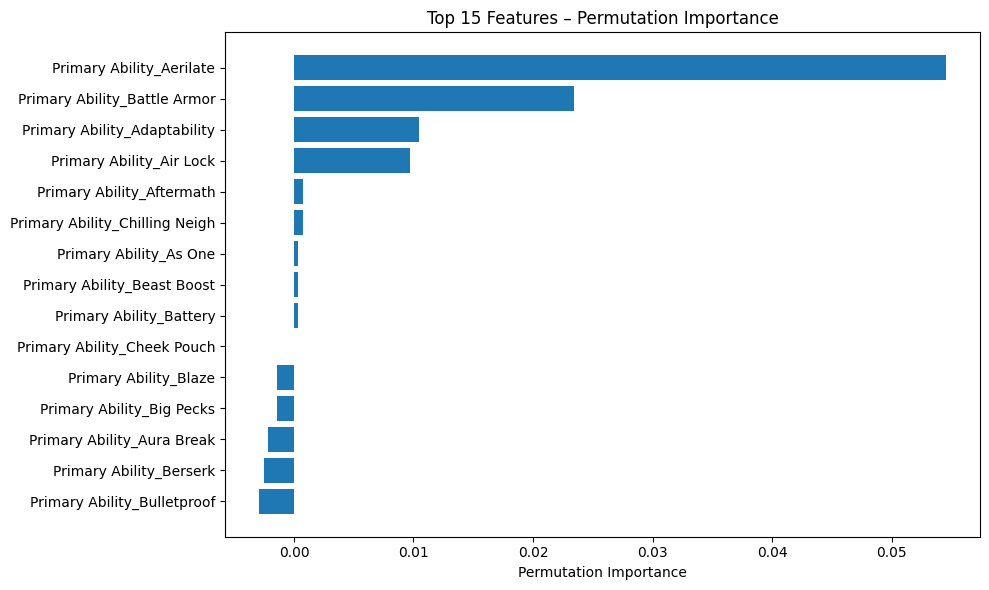

In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, cohen_kappa_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Load and clean
df = pd.read_csv("../../data/pokemon_database.csv")
df = df.applymap(lambda x: x.strip('"') if isinstance(x, str) else x)
# df = df[df['Alternate Form Name'].isnull()]
df['Classification'] = df['Classification'].str.replace("(?i)\\s*pokemon\\s*", "", regex=True).str.strip()

# 🎯 Target: Binary 'is_legendary' column
df['is_legendary'] = df['Legendary Type'].notnull().astype(int)

# Features
features = [
    'Primary Ability', 'Primary Egg Group', 'Secondary Egg Group',
    'Classification', 'Health Stat', 'Attack Stat', 'Defense Stat',
    'Special Attack Stat', 'Special Defense Stat', 'Speed Stat',
    'Base Stat Total'
]
df['is_pre_evolution'] = df['Pokemon Id'].isin(df['Pre-Evolution Pokemon Id'].dropna().astype(int))
features.append('is_pre_evolution')

# Normalize stats
for stat in ['Health Stat', 'Attack Stat', 'Defense Stat',
             'Special Attack Stat', 'Special Defense Stat', 'Speed Stat']:
    pct = f"{stat}_pct"
    df[pct] = (df[stat] / df['Base Stat Total']) * 100
    features.append(pct)

# Drop missing target
df_model = df[features + ['is_legendary']].dropna(subset=['is_legendary'])

X = df_model[features]
y = df_model['is_legendary']

categorical_features = ['Primary Ability', 'Primary Egg Group', 'Secondary Egg Group', 'Classification']
numeric_features = [col for col in X.columns if col not in categorical_features]

# Preprocessing
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('num', 'passthrough', numeric_features)
])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=200, random_state=42))
])

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Train + Predict
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation
print("Test set size:", len(y_test))
print("Class distribution (test):", np.bincount(y_test))
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Not Legendary", "Legendary"]))

print("Kappa Score:", round(cohen_kappa_score(y_test, y_pred), 3))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Legendary", "Legendary"])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax)
plt.title("Confusion Matrix – Legendary Prediction (Random Forest)")
plt.tight_layout()
plt.show()


# --- Feature names after encoding ---
onehot = model.named_steps['preprocessor'].transformers_[0][1]
cat_features = onehot.get_feature_names_out(categorical_features)
all_features = np.concatenate([cat_features, numeric_features])

### 🔥 1. Random Forest Built-in Importances (Top 15)
if hasattr(model.named_steps['classifier'], 'feature_importances_'):
    rf_importances = model.named_steps['classifier'].feature_importances_
    indices = np.argsort(rf_importances)[::-1]

    plt.figure(figsize=(10, 6))
    plt.barh(range(15), rf_importances[indices][:15][::-1])
    plt.yticks(range(15), all_features[indices][:15][::-1])
    plt.xlabel("Feature Importance")
    plt.title("Top 15 Features – Random Forest")
    plt.tight_layout()
    plt.show()

### 🔄 2. Permutation Importance (RF or MLP)
# Use the current model to evaluate
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
perm_importances = result.importances_mean
perm_indices = np.argsort(perm_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.barh(range(15), perm_importances[perm_indices][:15][::-1])
plt.yticks(range(15), all_features[perm_indices][:15][::-1])
plt.xlabel("Permutation Importance")
plt.title("Top 15 Features – Permutation Importance")
plt.tight_layout()
plt.show()

